In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
import torch.optim.lr_scheduler as tlrs
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN, R2CGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress
from pytorch_sklearn.frameworks.lr_schedulers import *

from pytorch_sklearn.neural_network.diffusion_network import DiffusionUtils

from sonn.building_blocks import Downsample2d, Upsample2d
from sonn.norm_layers import LayerNormNLP2d
from sonn.superonn_final import SuperONN2d

from PIL import Image

from collections import Iterable as CIterable
from typing import Iterable, Union, List
from pytorch_sklearn.utils.func_utils import to_device

In [2]:
mse = nn.MSELoss(reduction='none')
mse = mse.to('cuda')

In [3]:
mse(torch.randn(5), torch.randn(5))

tensor([0.2180, 0.0840, 0.2942, 1.5793, 0.7484])

In [4]:
to_device([torch.randn(5), 10, torch.randn(2)], 'cuda')

[tensor([-0.6657,  0.5014, -0.7138,  0.4761, -1.3332], device='cuda:0'),
 10,
 tensor([-0.4121,  0.8704], device='cuda:0')]

In [5]:
optim = torch.optim.Adam([torch.randn(1)], lr=1)
sched = tlrs.LinearLR(optim, start_factor=0.2, end_factor=0, total_iters=3)

In [6]:
optim = torch.optim.Adam([torch.randn(1)], lr=1)
sched = LinearLRScheduler(optim, 2, start_factor=0.2, end_factor=0, interval=[2, -1], store_lrs=True)

In [7]:
lrs

NameError: name 'lrs' is not defined

In [ ]:
lrs = [optim.param_groups[0]['lr']]
for i in range(10):
    try:
        sched.step_and_store_lr()
    except:
        sched.step()
    lrs.append(optim.param_groups[0]['lr'])
    
# plt.plot(sched.lrs)
# plt.show()
plt.plot(lrs)

In [ ]:
du = DiffusionUtils(20, 'linear')
du.beta

In [ ]:
t = 5

In [ ]:
du.beta[t]

In [ ]:
((1 - du.alpha_hat[t-1]) / (1 - du.alpha_hat[t]) * du.beta[t])

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class SimpleR2CCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        self.maxpool1 = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(3, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        y =  self.conv3(x)

        c = self.maxpool1(y)
        c = c.view(c.size(0), -1)
        c = self.fc(c)
        return y, c
    
class KillerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        return self.conv5(x)
    
class KillerONN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SuperONN2d(3, 32, q=3, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.ln1   = LayerNormNLP2d(64)
        self.conv2 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.ln2   = LayerNormNLP2d(128)
        self.conv3 = SuperONN2d(128, 128, q=3, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.ln3   = LayerNormNLP2d(64)
        self.conv4 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.ln4   = LayerNormNLP2d(32)
        self.conv5 = SuperONN2d(32, 3, q=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = self.ln1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = self.ln2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = self.ln3(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        x = self.ln4(x)
        return self.conv5(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [9]:
class LambdaWarmUpCosineScheduler:
    """
    note: use with a base_lr of 1.0
    """
    def __init__(self, warm_up_steps, lr_min, lr_max, lr_start, max_decay_steps):
        self.lr_warm_up_steps = warm_up_steps
        self.lr_start = lr_start
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.lr_max_decay_steps = max_decay_steps
        self.last_lr = 0.

    def schedule(self, n):
        if n < self.lr_warm_up_steps:
            lr = (self.lr_max - self.lr_start) / self.lr_warm_up_steps * n + self.lr_start
            self.last_lr = lr
            return lr
        else:
            t = (n - self.lr_warm_up_steps) / (self.lr_max_decay_steps - self.lr_warm_up_steps)
            t = min(t, 1.0)
            lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (
                    1 + np.cos(t * np.pi))
            self.last_lr = lr
            return lr

    def __call__(self, n, **kwargs):
        return self.schedule(n,**kwargs)

In [10]:
lwcosscheduler = LambdaWarmUpCosineScheduler(500, 0.0001, 0.001, 0.0001, 2000)
# coswarm = CosineWarmupScheduler(torch.optim.Adam([torch.randn(1)], lr=0.001), 1000, 2000)
mycoswarm = CosineWarmupLRScheduler(torch.optim.Adam([torch.randn(1)], lr=0.001), 500, 0.0001, 0.001, 0.0001, 2000, store_lrs=True)

c:\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


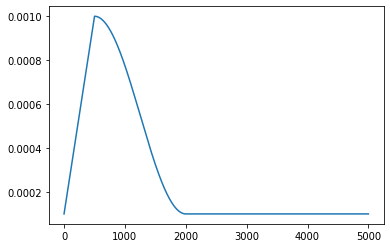

In [11]:
for i in range(5000):
    mycoswarm.step_and_store_lr()
plt.plot(mycoswarm.lrs)

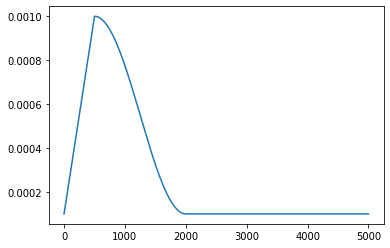

In [12]:
lrs = []
for i in range(5000):
    lrs.append(lwcosscheduler.schedule(i))
plt.plot(lrs)

In [13]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()
lrscheduler = AttentionLRScheduler(optim, 64, 400, lr_multiplier=1000, store_lrs=True)

In [14]:
for i in range(5000):
    lrscheduler.step_and_store_lr()

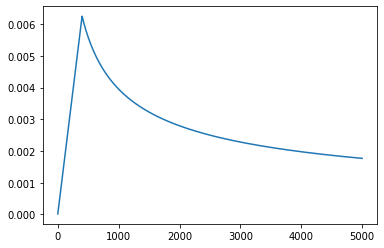

In [15]:
plt.plot(lrscheduler.lrs)

In [16]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [17]:
net = NeuralNetwork(model, optim, crit)

In [18]:
net.callbacks

In [ ]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

In [ ]:
net.predict(X)
gen = net.predict_generator(X)
for i in gen:
    print(i)
score = net.score(X, y)
print(score)

In [19]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [20]:
class ZenDataset(Dataset):
    def __init__(self):
        self.Zen = tvt.ToTensor()(Image.open('zen2.jpg')).unsqueeze(0)
        self.Bro = tvt.ToTensor()(Image.open('bro.jpg')).unsqueeze(0)

    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.Zen[index], self.Bro[index]

In [27]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A, *_ = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [28]:
G_A = SimpleCNN()
G_B = SimpleCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [29]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [30]:
cycle_gan_ds = CycleGANDataset()
zen_ds = ZenDataset()

In [31]:
std_metric = STDMetric()

In [34]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=200,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 201/400
1/1 [====================] - train_loss: 1.717 - train_std: 0.000 - Time: 0.10 - ETA: 0.00
Epoch 202/400
1/1 [====================] - train_loss: 1.713 - train_std: 0.000 - Time: 0.05 - ETA: 0.00
Epoch 203/400
1/1 [====================] - train_loss: 1.709 - train_std: 0.000 - Time: 0.05 - ETA: 0.00
Epoch 204/400
1/1 [====================] - train_loss: 1.704 - train_std: 0.000 - Time: 0.04 - ETA: 0.00
Epoch 205/400
1/1 [====================] - train_loss: 1.700 - train_std: 0.000 - Time: 0.04 - ETA: 0.00
Epoch 206/400
1/1 [====================] - train_loss: 1.696 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 207/400
1/1 [====================] - train_loss: 1.692 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 208/400
1/1 [====================] - train_loss: 1.688 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 209/400
1/1 [====================] - train_loss: 1.684 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 210/400
1/1 [====================] - train_loss: 

In [ ]:
cycle_gan.G_elo, cycle_gan.D_elo

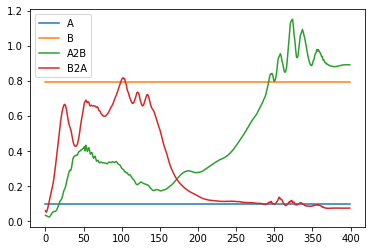

In [35]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

In [ ]:
preds = cycle_gan.predict(cycle_gan_ds)

In [ ]:
plt.plot(cycle_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(cycle_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(cycle_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(cycle_gan.history.track['train_D_B_loss'], label='D_B_loss')
# plt.ylim(0, 4)
plt.legend()
plt.show()

In [ ]:
preds = cycle_gan.predict(cycle_gan_ds)
score = cycle_gan.score(cycle_gan_ds)
print(score)
out_gen = cycle_gan.predict_generator(cycle_gan_ds)
for i in out_gen:
    print(i.__len__())

In [ ]:
NeuralNetwork.save_class(cycle_gan, 'cycle_gan.pkl')

In [ ]:
NeuralNetwork.load_class(cycle_gan, [], 'cycle_gan.pkl')

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(preds[0][0].permute(1, 2, 0).cpu(), vmin=preds[0][0].min(), vmax=preds[0][0].max())
plt.title('A2B')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(preds[1][0].permute(1, 2, 0).cpu(), vmin=preds[1][0].min(), vmax=preds[1][0].max())
plt.title('B2A')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(preds[2][0].permute(1, 2, 0).cpu(), vmin=preds[2][0].min(), vmax=preds[2][0].max())
plt.title('A2B2A')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(preds[3][0].permute(1, 2, 0).cpu(), vmin=preds[3][0].min(), vmax=preds[3][0].max())
plt.title('B2A2B')
plt.axis('off')
plt.gcf().tight_layout(w_pad=-10)
plt.show()

In [ ]:
[pred.std() for pred in preds]

In [ ]:
class R2CGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], 0, self.B[index], 1

In [ ]:
class SimpleR2CCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        self.maxpool1 = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(3, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        y =  self.conv3(x)

        c = self.maxpool1(y)
        c = c.view(c.size(0), -1)
        c = self.fc(c)
        
        return y, c

In [ ]:
class R2CSTDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, yA, B, yB = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [ ]:
G_A = SimpleR2CCNN()
G_B = SimpleR2CCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [ ]:
r2c_gan = R2CGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [ ]:
r2c_gan_ds = R2CGANDataset()

In [ ]:
std_metric = R2CSTDMetric()

In [ ]:
r2c_gan.fit(
    train_X=r2c_gan_ds,
    max_epochs=200,
    batch_size=10,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

In [ ]:
class Abc:
    pass

class Def:
    pass

In [ ]:
l = [Abc, Def]

ll = [type(el).__name__ for el in l]
ll

In [ ]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

In [ ]:
plt.plot(r2c_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(r2c_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(r2c_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(r2c_gan.history.track['train_D_B_loss'], label='D_B_loss')
# plt.ylim(0, 4)
plt.legend()
plt.show()